### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple Rescorla-Wagner reinforcement learning model (i.e., simulations, model fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import pickle, datetime
from scipy.stats import norm, beta, gamma
from tqdm import tqdm

In [3]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, norm2beta, alpha2norm, beta2norm, compGauss_ms, calc_BICint, calc_LME
from pyEM import plotting
import rw_models

In [4]:
modelID = 'RW'
param_names = ['beta', 'lr']
objfunc_dict = {modelID: rw_models.fit}
simul_dict   = {modelID: rw_models.simulate}

nsubjects = 150
betamin, betamax   = .75,  10
alphamin, alphamax = .05, .95

params = np.ones((nsubjects, 2))
for simS in tqdm(range(nsubjects)):
    # For beta, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    params[simS, 0] = norm.rvs(0, scale=1)
    while params[simS, 0] > betamax or params[simS, 0] < betamin:
        params[simS, 0] = norm2beta(norm.rvs(0, scale=1))

    # For alpha, we will sample from a beta distribution and then transform
    params[simS, 1] = beta.rvs(1.1, 1.1)
    while params[simS, 1] > alphamax or params[simS, 1] < alphamin:
        params[simS, 1] = beta.rvs(1.1, 1.1)

100%|██████████| 150/150 [00:00<00:00, 7150.84it/s]


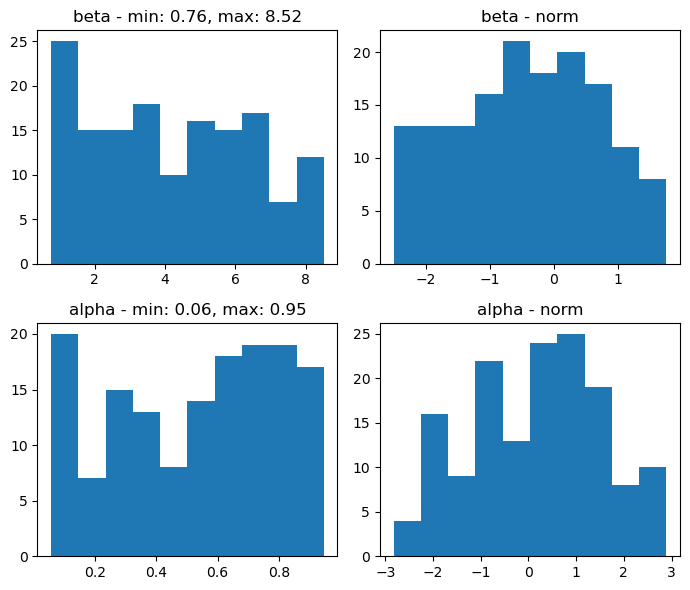

In [5]:
# plot 2 x 2
plt.figure(figsize=(7, 6))
plt.subplot(221)
plt.hist(params[:,0]);
plt.title(f'beta - min: {min(params[:,0]):.2f}, max: {max(params[:,0]):.2f}');

plt.subplot(222)
plt.hist(beta2norm(params[:,0]));
plt.title(f'beta - norm');

plt.subplot(223)
plt.hist(params[:,1]);
plt.title(f'alpha - min: {min(params[:,1]):.2f}, max: {max(params[:,1]):.2f}');

plt.subplot(224)
plt.hist(alpha2norm(params[:,1]));
plt.title(f'alpha - norm');

plt.tight_layout()

In [6]:
ntrials, nblocks = 24, 6
print(f'ntrials: {ntrials}, nblocks: {nblocks}')

simulfunc = simul_dict['RW']
subj_dict = simulfunc(params, nblocks=nblocks, ntrials=ntrials)

ntrials: 24, nblocks: 6


100%|██████████| 150/150 [00:01<00:00, 80.02it/s]


In [7]:
print(subj_dict.keys())

dict_keys(['params', 'ev', 'ch_prob', 'choices', 'choices_A', 'rewards', 'pe', 'choice_nll'])


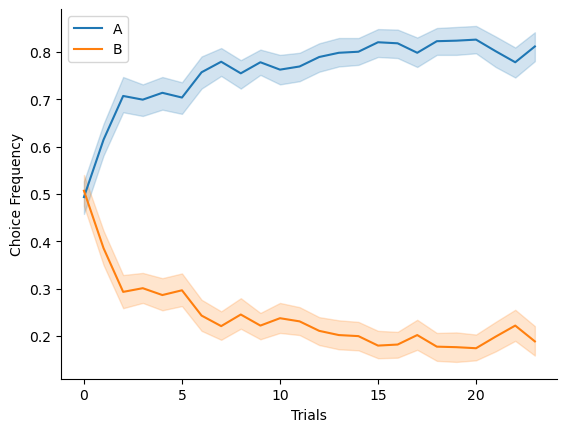

In [8]:
plotting.plot_choices(subj_dict['choices_A']) 

In [9]:
# create a list of lists with choices and rewards for each subject
all_data = []
for idx, (choices, rewards) in enumerate(zip(subj_dict['choices'], subj_dict['rewards'])):
    all_data += [[choices, rewards]]

In [10]:
output_dict = EMfit(all_data, objfunc_dict['RW'], param_names, mstep_maxit=100)
m, inv_h, posterior, NPL, NLPrior, NLL, convergence = output_dict.values()

10713.910 (000), 9342.883 (001), 9279.053 (002), 9265.115 (003), 9260.400 (004), 9258.073 (005), 9256.706 (006), 9256.109 (007), 9255.558 (008), 9255.251 (009), 9255.119 (010), 9255.035 (011), 9255.009 (012), 9254.898 (013), 9254.857 (015), 9254.852 (016), 9254.806 (019),  -- CONVERGED!!!!!


In [11]:
## Now store all relevant outputs in modout dict and save it
save_fit = False

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')
modout[modelID]['behavior'] = subj_dict  # copy behavior here

# Fill in fit information
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
        if 'beta' in param_name:
            est_params[subj_idx, param_idx] = norm2beta(m[param_idx, subj_idx])
        elif 'lr' in param_name:
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior
modout[modelID]['fit']['BICint'] = calc_BICint(all_data, param_names, posterior['mu'], posterior['sigma'], rw_models.fit)

# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['ev']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modout[modelID]['fit']['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modout[modelID]['fit']['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modout[modelID]['fit']['choices_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['pe']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['negll']       = np.zeros((nsubjects,))

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
Laplace_approx, lme, goodHessian = calc_LME(inv_h, NPL)
modout[modelID]['fit']['Laplace_approx'] = Laplace_approx
modout[modelID]['fit']['lme'] = lme
modout[modelID]['fit']['goodHessian'] = goodHessian
for subj_idx in range(nsubjects):
    # Get subjectwise model predictions# get info for current subject
    choices = subj_dict['choices'][subj_idx,:,:]
    rewards = subj_dict['rewards'][subj_idx,:,:]
    
    model_fits = rw_models.fit(m[:,subj_idx], choices, rewards, prior=None, output='all')

    # store model fits
    modout[modelID]['fit']['ev'][subj_idx,:,:,:] = model_fits['ev']
    modout[modelID]['fit']['ch_prob'][subj_idx,:,:,:] = model_fits['ch_prob']
    modout[modelID]['fit']['choices'][subj_idx,:,:] = model_fits['choices']
    modout[modelID]['fit']['choices_A'][subj_idx,:,:] = model_fits['choices_A']
    modout[modelID]['fit']['rewards'][subj_idx,:,:] = model_fits['rewards']
    modout[modelID]['fit']['pe'][subj_idx,:,:] = model_fits['pe']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']

# Save output
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modout, f)

Good Hessians: 150 out of 150


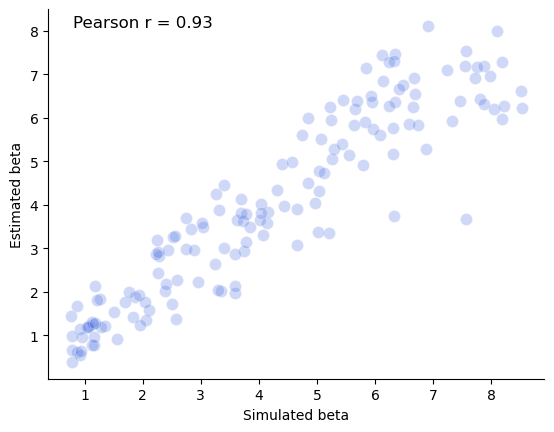

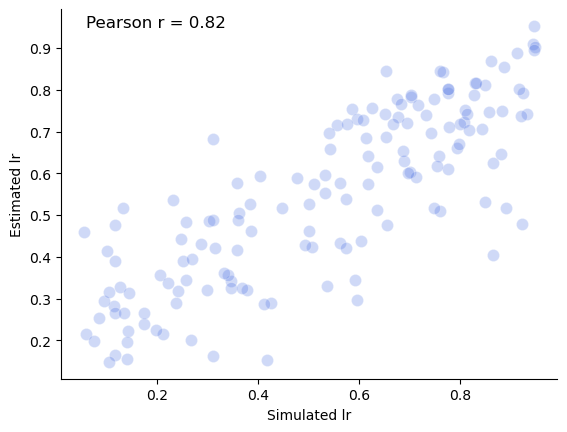

In [12]:
for param_idx, param_label in enumerate(['beta', 'lr']):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = est_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

In [13]:
## Code if you want to open in MATLAB (leaving here for Shawn to reference so he doesn't have search for it again)

# import scipy.io
# # Save m and h to a .mat file
# data = {'m': m, 'h': inv_h}
# scipy.io.savemat('Mean_Hess_example.mat', data)

# curmu,cursigma,flagcov,covmat_out = compGauss_ms(m,inv_h,2)
# print(curmu,cursigma,flagcov,covmat_out )